# CardioIA - Fase 4: Assistente médico com Visão Computacional

**Projeto:** Classificação de Imagens de Raio-X de Tórax (NORMAL vs PNEUMONIA)  
## 👨‍🎓 Integrantes
- Bruno Castro - RM558359
- Hugo Mariano - RM560688
- Matheus Castro - RM559293 
**Instituição:** FIAP  
**Dataset:** Chest X-Ray Images (Pneumonia) - Kaggle  

---

## 📋 Índice

1. [Introdução e Contexto](#1-introducao)
2. [Importação de Bibliotecas](#2-bibliotecas)
3. [Configurações Globais](#3-configuracoes)
4. [Exploração dos Dados](#4-exploracao)
5. [Pré-processamento](#5-preprocessamento)
6. [Modelo 1: CNN do Zero](#6-cnn-baseline)
7. [Modelo 2: Transfer Learning](#7-transfer-learning)
8. [Comparação de Resultados](#8-comparacao)
9. [Demo Interativa](#9-demo)
10. [Conclusões e Próximos Passos](#10-conclusoes)

---

## 1. Introdução e Contexto {#1-introducao}

### 🎯 Objetivo do Projeto

Desenvolver um protótipo de **Assistente Cardiológico Virtual** utilizando técnicas de **Visão Computacional** e **Deep Learning** para auxiliar na análise de imagens médicas de raio-X de tórax.

### 📊 Problema a Resolver

Classificar imagens de raio-X de tórax em duas categorias:
- **NORMAL**: Pulmões saudáveis
- **PNEUMONIA**: Presença de pneumonia

### 📦 Dataset Utilizado

**Chest X-Ray Images (Pneumonia)** - Kaggle
- **Total de imagens:** 5.856
- **Treino:** 5.216 imagens (1.341 NORMAL, 3.875 PNEUMONIA)
- **Teste:** 624 imagens (234 NORMAL, 390 PNEUMONIA)
- **Validação:** 16 imagens (8 NORMAL, 8 PNEUMONIA)
- **Desbalanceamento:** Proporção 2.89:1 (PNEUMONIA/NORMAL)

### 🎓 Abordagens Implementadas

1. **CNN do Zero:** Rede neural convolucional construída desde o início
2. **Transfer Learning:** Utilizando modelo pré-treinado (VGG16 ou ResNet50)

### 💡 Relevância Clínica

A detecção precoce de pneumonia é crucial para o tratamento adequado. Um modelo de IA pode:
- Auxiliar radiologistas na triagem de casos
- Acelerar o diagnóstico em áreas com recursos limitados
- Reduzir erros humanos por fadiga
- **Atenção:** Recall (sensibilidade) é crítico - perdas casos positivos pode ser fatal!

---

## 2. Importação de Bibliotecas {#2-bibliotecas}

In [13]:
# Manipulação de dados e sistema
import os
import numpy as np
import pandas as pd
from pathlib import Path

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de imagens
from PIL import Image

# TensorFlow e Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50

# Métricas e avaliação
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight

# Utilidades
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurar seeds para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ TensorFlow version: 2.20.0
✅ GPU Available: False


## 3. Configurações Globais {#3-configuracoes}

In [14]:
# Caminhos do projeto
BASE_DIR = Path('..')
DATASET_DIR = BASE_DIR / 'dataset'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'
REPORTS_DIR = BASE_DIR / 'reports'

# Criar diretórios se não existirem
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)
REPORTS_DIR.mkdir(exist_ok=True)

# Parâmetros de imagens
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Parâmetros de treinamento
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001

# Classes
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']
NUM_CLASSES = len(CLASS_NAMES)

# Configuração de plotagem
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Configurações globais definidas")
print(f"📁 Dataset directory: {DATASET_DIR}")
print(f"🖼️  Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Epochs: {EPOCHS}")

✅ Configurações globais definidas
📁 Dataset directory: ..\dataset
🖼️  Image size: 224x224x3
📦 Batch size: 32
🔄 Epochs: 25


## 4. Exploração dos Dados {#4-exploracao}

### 4.1 Análise da Estrutura do Dataset

In [15]:
# Mapear estrutura do dataset
print("=" * 60)
print("ESTRUTURA DO DATASET")
print("=" * 60)
print()

dataset_stats = {}

for subset in ['train', 'test', 'val']:
    print(f"📂 {subset.upper()}/")
    subset_path = DATASET_DIR / subset
    
    subset_stats = {}
    
    for classe in CLASS_NAMES:
        classe_path = subset_path / classe
        images = list(classe_path.glob('*.jpeg'))
        n_images = len(images)
        
        subset_stats[classe] = n_images
        print(f"   ✅ {classe:<12} {n_images:>5} imagens")
    
    dataset_stats[subset] = subset_stats
    total = sum(subset_stats.values())
    print(f"   {'TOTAL':<12} {total:>5} imagens")
    print()

print("=" * 60)

ESTRUTURA DO DATASET

📂 TRAIN/
   ✅ NORMAL        1341 imagens
   ✅ PNEUMONIA     3875 imagens
   TOTAL         5216 imagens

📂 TEST/
   ✅ NORMAL         234 imagens
   ✅ PNEUMONIA      390 imagens
   TOTAL          624 imagens

📂 VAL/
   ✅ NORMAL           8 imagens
   ✅ PNEUMONIA        8 imagens
   TOTAL           16 imagens



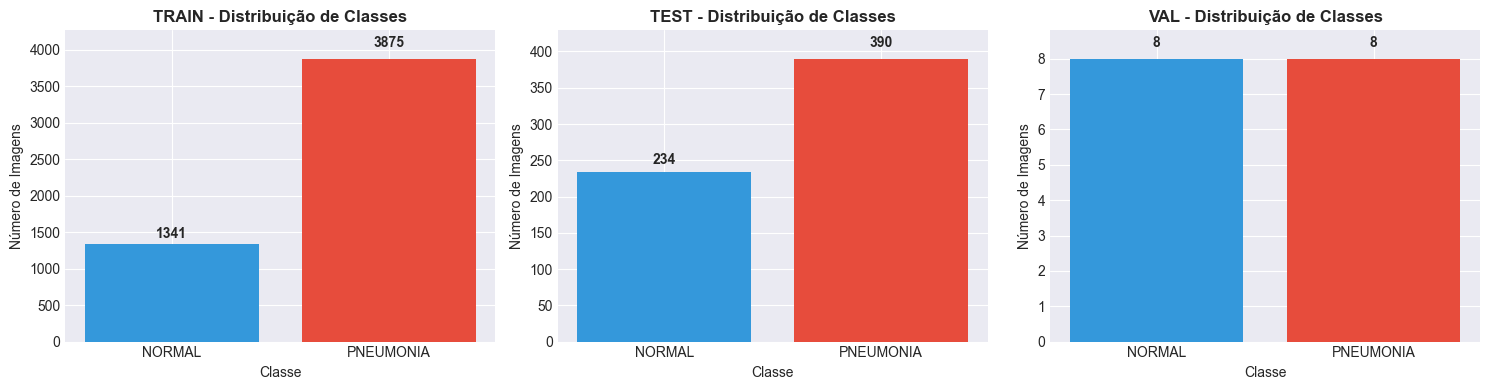

✅ Gráfico salvo em results/dataset_distribution.png


In [16]:
# Visualizar distribuição de classes (CORRIGIDO)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, subset in enumerate(['train', 'test', 'val']):
    data = dataset_stats[subset]
    bars = axes[idx].bar(data.keys(), data.values(), color=['#3498db', '#e74c3c'])
    axes[idx].set_title(f'{subset.upper()} - Distribuição de Classes', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Número de Imagens')
    axes[idx].set_xlabel('Classe')
    
    # Adicionar valores nas barras com posicionamento adaptativo
    for i, (key, value) in enumerate(data.items()):
        # Posicionar o texto proporcional ao valor (3% acima da barra)
        offset = value * 0.03
        axes[idx].text(i, value + offset, str(value), 
                      ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Ajustar limite superior do eixo Y (adicionar 10% de margem)
    max_value = max(data.values())
    axes[idx].set_ylim(0, max_value * 1.1)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico salvo em results/dataset_distribution.png")


### 4.2 Análise de Balanceamento e Class Weights

In [17]:
# Calcular proporção de classes no treino
train_normal = dataset_stats['train']['NORMAL']
train_pneumonia = dataset_stats['train']['PNEUMONIA']
ratio = train_pneumonia / train_normal

print("📊 ANÁLISE DE BALANCEAMENTO NO CONJUNTO DE TREINO:")
print()
print(f"   NORMAL:    {train_normal:>5} imagens ({train_normal/(train_normal+train_pneumonia)*100:.1f}%)")
print(f"   PNEUMONIA: {train_pneumonia:>5} imagens ({train_pneumonia/(train_normal+train_pneumonia)*100:.1f}%)")
print()
print(f"   Proporção PNEUMONIA/NORMAL: {ratio:.2f}:1")
print()

if ratio > 1.5:
    print("   ⚠️  Dataset DESBALANCEADO!")
    print("   → Estratégia: Usar class_weight durante o treinamento")
else:
    print("   ✅ Dataset razoavelmente balanceado")

# Calculo class weights
# Para binário: weight = total_samples / (num_classes * samples_per_class)
total_train = train_normal + train_pneumonia
weight_normal = total_train / (2 * train_normal)
weight_pneumonia = total_train / (2 * train_pneumonia)

class_weights = {0: weight_normal, 1: weight_pneumonia}

print()
print("🎯 CLASS WEIGHTS CALCULADOS:")
print(f"   NORMAL (0):    {weight_normal:.4f}")
print(f"   PNEUMONIA (1): {weight_pneumonia:.4f}")
print()
print("   Esses pesos serão usados durante o treinamento para")
print("   balancear a importância de cada classe.")

📊 ANÁLISE DE BALANCEAMENTO NO CONJUNTO DE TREINO:

   NORMAL:     1341 imagens (25.7%)
   PNEUMONIA:  3875 imagens (74.3%)

   Proporção PNEUMONIA/NORMAL: 2.89:1

   ⚠️  Dataset DESBALANCEADO!
   → Estratégia: Usar class_weight durante o treinamento

🎯 CLASS WEIGHTS CALCULADOS:
   NORMAL (0):    1.9448
   PNEUMONIA (1): 0.6730

   Esses pesos serão usados durante o treinamento para
   balancear a importância de cada classe.


### 4.3 Visualização de Amostras do Dataset

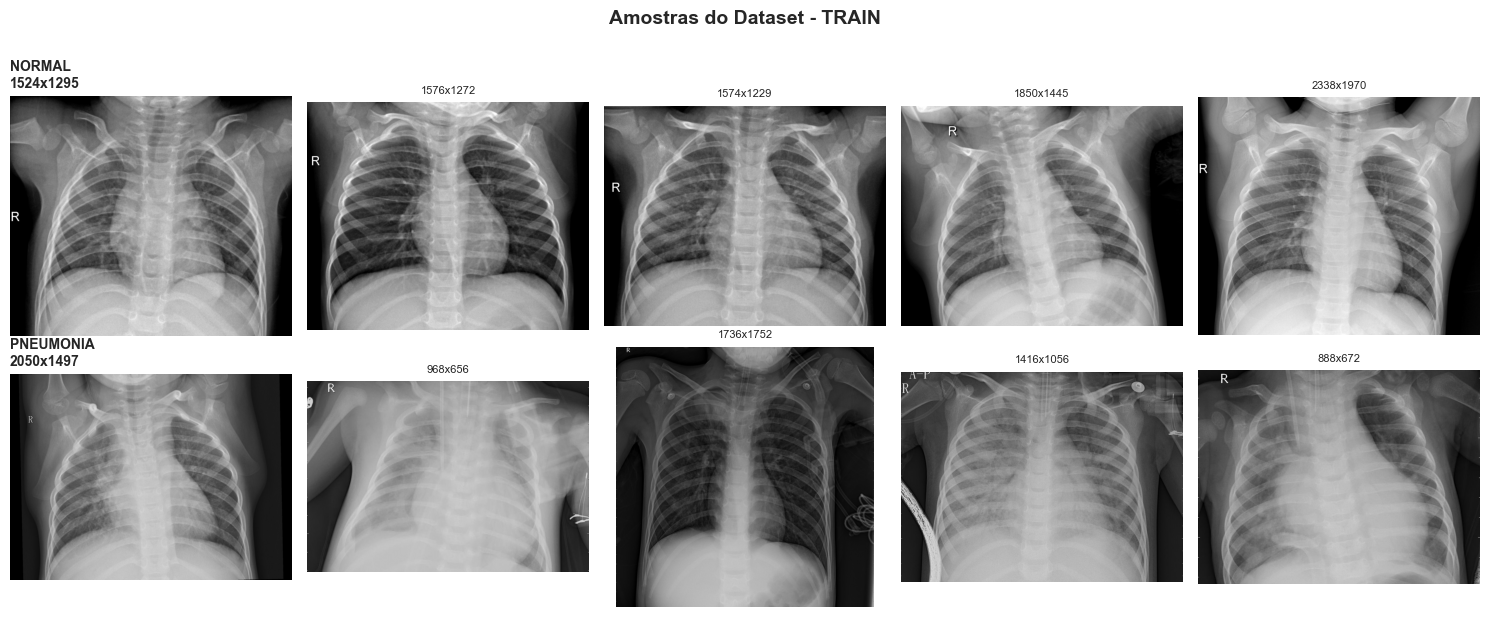

✅ Amostras visualizadas e salvas


In [18]:
# Função para visualizar amostras
def visualize_samples(subset='train', samples_per_class=5):
    """
    Visualiza amostras aleatórias de cada classe
    """
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 6))
    
    for class_idx, classe in enumerate(CLASS_NAMES):
        classe_path = DATASET_DIR / subset / classe
        images = list(classe_path.glob('*.jpeg'))
        
        # Selecionar amostras aleatórias
        selected = np.random.choice(images, samples_per_class, replace=False)
        
        for img_idx, img_path in enumerate(selected):
            img = Image.open(img_path)
            axes[class_idx, img_idx].imshow(img, cmap='gray')
            axes[class_idx, img_idx].axis('off')
            
            if img_idx == 0:
                axes[class_idx, img_idx].set_title(
                    f'{classe}\n{img.size[0]}x{img.size[1]}',
                    fontsize=10,
                    fontweight='bold',
                    loc='left'
                )
            else:
                axes[class_idx, img_idx].set_title(
                    f'{img.size[0]}x{img.size[1]}',
                    fontsize=8
                )
    
    plt.suptitle(f'Amostras do Dataset - {subset.upper()}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'samples_{subset}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualizar amostras do conjunto de treino
visualize_samples('train', samples_per_class=5)
print("✅ Amostras visualizadas e salvas")

### 4.4 Análise de Dimensões das Imagens

Analisando dimensões de 100 imagens aleatórias...


Classe PNEUMONIA: 100%|██████████| 50/50 [00:00<00:00, 11137.29it/s]


📏 ESTATÍSTICAS DE DIMENSÕES:
             width       height
count   100.000000   100.000000
mean   1442.730000  1109.170000
std     370.686065   414.777829
min     741.000000   421.000000
25%    1166.000000   752.000000
50%    1439.000000  1044.000000
75%    1716.000000  1353.250000
max    2566.000000  2411.000000


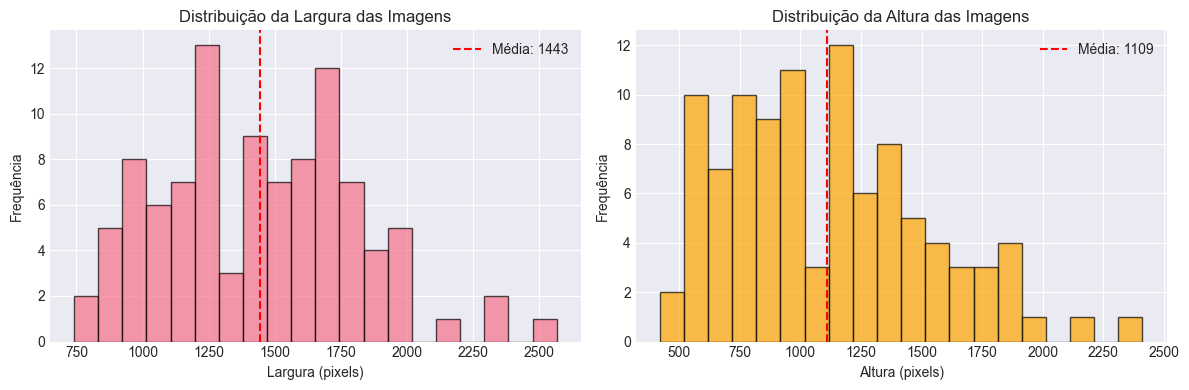


✅ Análise de dimensões concluída
📊 Todas as imagens serão redimensionadas para 224x224 durante o pré-processamento


In [19]:
# Analisar dimensões de uma amostra de imagens
sample_size = 100
dimensions = []

print(f"Analisando dimensões de {sample_size} imagens aleatórias...")

for classe in CLASS_NAMES:
    classe_path = DATASET_DIR / 'train' / classe
    images = list(classe_path.glob('*.jpeg'))
    selected = np.random.choice(images, min(sample_size // 2, len(images)), replace=False)
    
    for img_path in tqdm(selected, desc=f"Classe {classe}"):
        img = Image.open(img_path)
        dimensions.append({
            'width': img.size[0],
            'height': img.size[1],
            'class': classe
        })

df_dims = pd.DataFrame(dimensions)

print("\n📏 ESTATÍSTICAS DE DIMENSÕES:")
print(df_dims.describe())

# Visualizar distribuição
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_dims['width'], bins=20, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Largura (pixels)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição da Largura das Imagens')
axes[0].axvline(df_dims['width'].mean(), color='red', linestyle='--', label=f'Média: {df_dims["width"].mean():.0f}')
axes[0].legend()

axes[1].hist(df_dims['height'], bins=20, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Altura (pixels)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição da Altura das Imagens')
axes[1].axvline(df_dims['height'].mean(), color='red', linestyle='--', label=f'Média: {df_dims["height"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'image_dimensions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Análise de dimensões concluída")
print(f"📊 Todas as imagens serão redimensionadas para {IMG_HEIGHT}x{IMG_WIDTH} durante o pré-processamento")

---

## ✅ Checkpoint 1 - Exploração dos Dados

Antes de prosseguir, verifique:
- [x] Estrutura do dataset mapeada
- [x] Distribuição de classes analisada
- [x] Class weights calculados
- [x] Amostras visualizadas
- [x] Dimensões das imagens analisadas

**Próxima etapa:** Pré-processamento e preparação dos dados

---

In [20]:
# Criar ImageDataGenerators com data augmentation

print("=" * 60)
print("CONFIGURANDO IMAGEDATAGENERATORS")
print("=" * 60)
print()

# Generator para TREINO com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalização (0-255 → 0-1)
    rotation_range=15,           # Rotação aleatória de até 15 graus
    width_shift_range=0.1,       # Deslocamento horizontal de até 10%
    height_shift_range=0.1,      # Deslocamento vertical de até 10%
    shear_range=0.1,             # Distorção de cisalhamento
    zoom_range=0.1,              # Zoom aleatório de até 10%
    horizontal_flip=True,        # Flip horizontal aleatório
    fill_mode='nearest'          # Preencher pixels criados com nearest neighbor
)

# Generator para VALIDAÇÃO (sem augmentation, apenas normalização)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator para TESTE (sem augmentation, apenas normalização)
test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ ImageDataGenerators configurados com sucesso!")
print()
print("📊 CONFIGURAÇÕES DE DATA AUGMENTATION (treino):")
print(f"   • Normalização: rescale=1/255")
print(f"   • Rotação: ±15 graus")
print(f"   • Deslocamento: ±10% (horizontal e vertical)")
print(f"   • Shear: até 10%")
print(f"   • Zoom: ±10%")
print(f"   • Flip horizontal: Sim")
print()
print("📊 VALIDAÇÃO E TESTE:")
print(f"   • Apenas normalização (rescale=1/255)")


CONFIGURANDO IMAGEDATAGENERATORS

✅ ImageDataGenerators configurados com sucesso!

📊 CONFIGURAÇÕES DE DATA AUGMENTATION (treino):
   • Normalização: rescale=1/255
   • Rotação: ±15 graus
   • Deslocamento: ±10% (horizontal e vertical)
   • Shear: até 10%
   • Zoom: ±10%
   • Flip horizontal: Sim

📊 VALIDAÇÃO E TESTE:
   • Apenas normalização (rescale=1/255)


In [21]:
# Criar generators que apontam para os diretórios do dataset

print("=" * 60)
print("CRIANDO DATA LOADERS")
print("=" * 60)
print()

# Generator de TREINO
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR / 'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Classificação binária
    color_mode='rgb',     # Imagens coloridas (3 canais)
    shuffle=True,         # Embaralhar dados a cada epoch
    seed=42               # Seed para reprodutibilidade
)

print()

# Generator de VALIDAÇÃO
validation_generator = val_datagen.flow_from_directory(
    DATASET_DIR / 'val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,  # Não embaralhar validação
    seed=42
)

print()

# Generator de TESTE
test_generator = test_datagen.flow_from_directory(
    DATASET_DIR / 'test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,  # Não embaralhar teste
    seed=42
)

print()
print("=" * 60)
print("RESUMO DOS GENERATORS")
print("=" * 60)
print()
print(f"📊 TREINO:")
print(f"   • Total de imagens: {train_generator.samples}")
print(f"   • Batches por epoch: {len(train_generator)}")
print(f"   • Classes: {train_generator.class_indices}")
print()
print(f"📊 VALIDAÇÃO:")
print(f"   • Total de imagens: {validation_generator.samples}")
print(f"   • Batches por epoch: {len(validation_generator)}")
print()
print(f"📊 TESTE:")
print(f"   • Total de imagens: {test_generator.samples}")
print(f"   • Batches por epoch: {len(test_generator)}")
print()
print("✅ Data loaders criados com sucesso!")


CRIANDO DATA LOADERS

Found 5216 images belonging to 2 classes.

Found 16 images belonging to 2 classes.

Found 624 images belonging to 2 classes.

RESUMO DOS GENERATORS

📊 TREINO:
   • Total de imagens: 5216
   • Batches por epoch: 163
   • Classes: {'NORMAL': 0, 'PNEUMONIA': 1}

📊 VALIDAÇÃO:
   • Total de imagens: 16
   • Batches por epoch: 1

📊 TESTE:
   • Total de imagens: 624
   • Batches por epoch: 20

✅ Data loaders criados com sucesso!


In [22]:
# Testar se os generators estão funcionando corretamente

print("=" * 60)
print("VALIDANDO PIPELINE DE DADOS")
print("=" * 60)
print()

# Carregar um batch de treino para teste
print("📦 Carregando um batch de TREINO...")
sample_batch_images, sample_batch_labels = next(train_generator)

print(f"✅ Batch carregado com sucesso!")
print()
print(f"📊 INFORMAÇÕES DO BATCH:")
print(f"   • Shape das imagens: {sample_batch_images.shape}")
print(f"   • Shape das labels: {sample_batch_labels.shape}")
print(f"   • Tipo de dado: {sample_batch_images.dtype}")
print(f"   • Range de valores: [{sample_batch_images.min():.4f}, {sample_batch_images.max():.4f}]")
print()

# Verificar se a normalização foi aplicada
if sample_batch_images.max() <= 1.0 and sample_batch_images.min() >= 0.0:
    print("✅ NORMALIZAÇÃO OK: Valores entre 0 e 1")
else:
    print("⚠️  ATENÇÃO: Valores fora do range esperado [0, 1]")

print()

# Verificar shape esperado
expected_shape = (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
if sample_batch_images.shape == expected_shape:
    print(f"✅ SHAPE OK: {expected_shape}")
else:
    print(f"⚠️  Shape encontrado: {sample_batch_images.shape}")
    print(f"   Shape esperado: {expected_shape}")

print()

# Verificar distribuição de classes no batch
print(f"📊 DISTRIBUIÇÃO DE CLASSES NO BATCH:")
print(f"   • Classe 0 (NORMAL): {(sample_batch_labels == 0).sum()} imagens")
print(f"   • Classe 1 (PNEUMONIA): {(sample_batch_labels == 1).sum()} imagens")

print()
print("=" * 60)
print("✅ VALIDAÇÃO CONCLUÍDA - Pipeline funcionando corretamente!")
print("=" * 60)


VALIDANDO PIPELINE DE DADOS

📦 Carregando um batch de TREINO...
✅ Batch carregado com sucesso!

📊 INFORMAÇÕES DO BATCH:
   • Shape das imagens: (32, 224, 224, 3)
   • Shape das labels: (32,)
   • Tipo de dado: float32
   • Range de valores: [0.0000, 1.0000]

✅ NORMALIZAÇÃO OK: Valores entre 0 e 1

✅ SHAPE OK: (32, 224, 224, 3)

📊 DISTRIBUIÇÃO DE CLASSES NO BATCH:
   • Classe 0 (NORMAL): 12 imagens
   • Classe 1 (PNEUMONIA): 20 imagens

✅ VALIDAÇÃO CONCLUÍDA - Pipeline funcionando corretamente!


VISUALIZANDO DATA AUGMENTATION



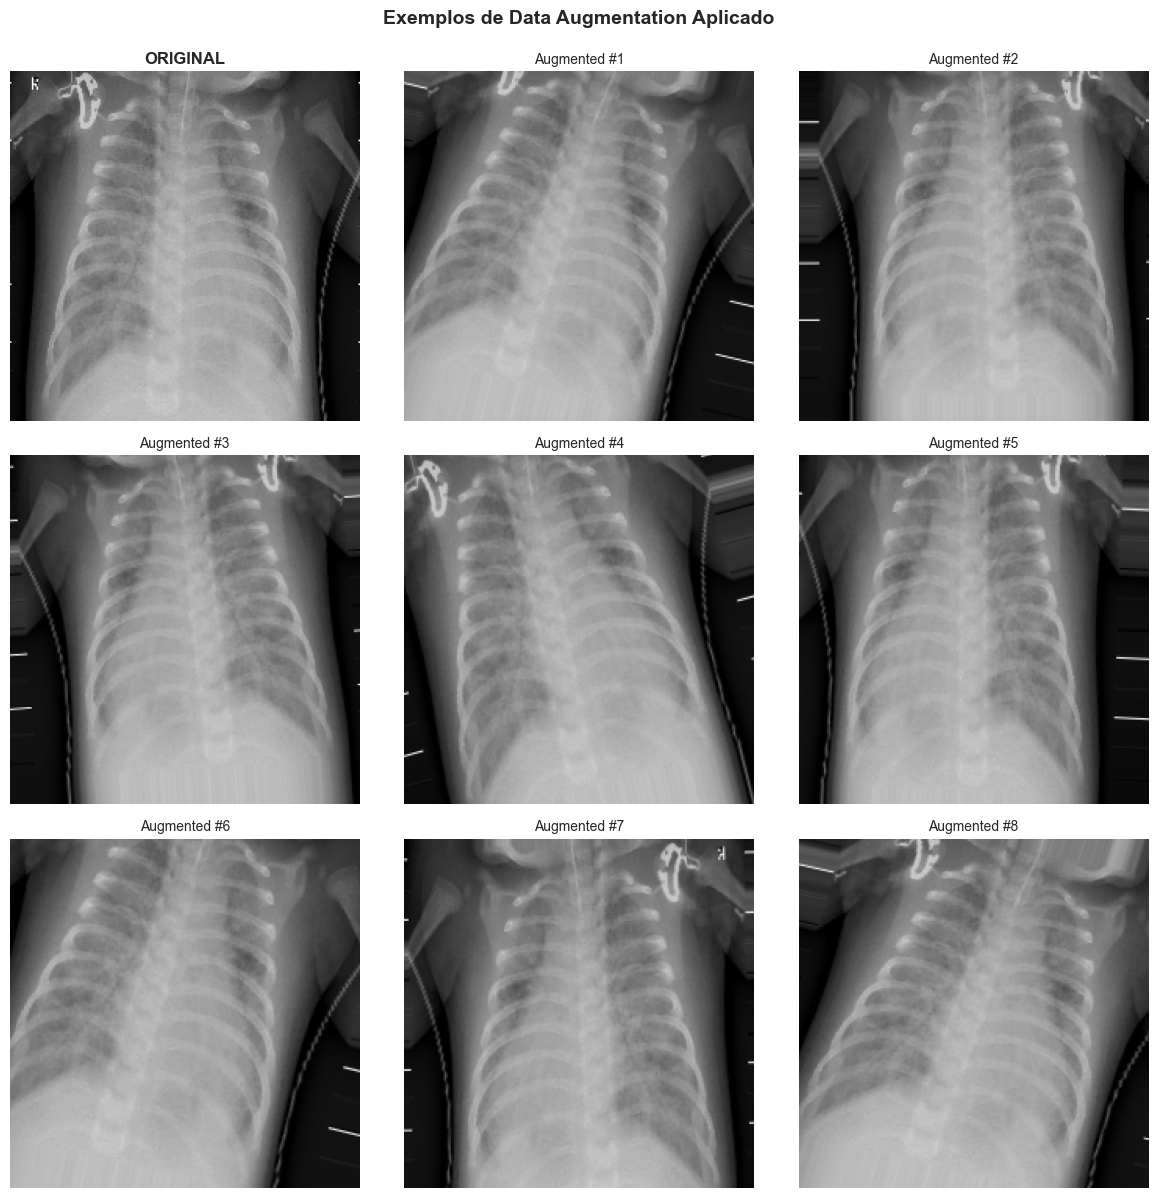

✅ Visualização de data augmentation criada!
📁 Salvo em: results/data_augmentation_examples.png

🎉 ETAPA 2: PRÉ-PROCESSAMENTO CONCLUÍDA!


In [23]:
# Visualizar exemplos de data augmentation

print("=" * 60)
print("VISUALIZANDO DATA AUGMENTATION")
print("=" * 60)
print()

# Selecionar uma imagem original para aplicar augmentation
sample_img_path = list((DATASET_DIR / 'train' / 'PNEUMONIA').glob('*.jpeg'))[0]
sample_img = load_img(sample_img_path, target_size=IMG_SIZE)
sample_array = img_to_array(sample_img)
sample_array = sample_array.reshape((1,) + sample_array.shape)  # Adicionar dimensão de batch

# Criar um generator temporário para data augmentation
augmentation_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerar 8 exemplos de augmentation
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Imagem original
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('ORIGINAL', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Gerar 8 versões augmentadas
aug_iter = augmentation_gen.flow(sample_array, batch_size=1)
for i in range(1, 9):
    row = i // 3
    col = i % 3
    
    augmented_img = next(aug_iter)[0]
    axes[row, col].imshow(augmented_img)
    axes[row, col].set_title(f'Augmented #{i}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle('Exemplos de Data Augmentation Aplicado', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'data_augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualização de data augmentation criada!")
print(f"📁 Salvo em: results/data_augmentation_examples.png")
print()
print("=" * 60)
print("🎉 ETAPA 2: PRÉ-PROCESSAMENTO CONCLUÍDA!")
print("=" * 60)


In [24]:
# Construir arquitetura de CNN do zero

print("=" * 60)
print("CONSTRUINDO CNN BASELINE (DO ZERO)")
print("=" * 60)
print()

# Limpar sessão anterior do Keras (liberar memória)
tf.keras.backend.clear_session()

# Criar modelo Sequential
model_cnn = models.Sequential([
    # Bloco Convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='conv1'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Bloco Convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Bloco Convolucional 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Bloco Convolucional 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='pool4'),
    
    # Flatten e Camadas Densas
    layers.Flatten(name='flatten'),
    layers.Dense(512, activation='relu', name='fc1'),
    layers.Dropout(0.5, name='dropout1'),
    layers.Dense(256, activation='relu', name='fc2'),
    layers.Dropout(0.3, name='dropout2'),
    
    # Camada de Saída (classificação binária)
    layers.Dense(1, activation='sigmoid', name='output')
], name='CNN_Baseline')

print("✅ Arquitetura da CNN criada!")
print()
print("=" * 60)
print("RESUMO DO MODELO")
print("=" * 60)
print()
model_cnn.summary()

print()
print("=" * 60)
print("ANÁLISE DE PARÂMETROS")
print("=" * 60)
print()

# Calcular total de parâmetros
total_params = model_cnn.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_cnn.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"📊 Total de parâmetros: {total_params:,}")
print(f"   • Treináveis: {trainable_params:,}")
print(f"   • Não-treináveis: {non_trainable_params:,}")
print()
print("✅ Modelo pronto para compilação!")


CONSTRUINDO CNN BASELINE (DO ZERO)

✅ Arquitetura da CNN criada!

RESUMO DO MODELO



Model: "CNN_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)


ANÁLISE DE PARÂMETROS

📊 Total de parâmetros: 26,212,545
   • Treináveis: 26,211,585
   • Não-treináveis: 960

✅ Modelo pronto para compilação!


In [25]:
# Compilar modelo com otimizador, loss e métricas

print("=" * 60)
print("COMPILANDO MODELO CNN BASELINE")
print("=" * 60)
print()

# Compilar modelo
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',  # Para classificação binária
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("✅ Modelo compilado com sucesso!")
print()
print("📊 CONFIGURAÇÕES:")
print(f"   • Otimizador: Adam")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Loss Function: binary_crossentropy")
print(f"   • Métricas: accuracy, precision, recall, AUC")
print()
print("=" * 60)


COMPILANDO MODELO CNN BASELINE

✅ Modelo compilado com sucesso!

📊 CONFIGURAÇÕES:
   • Otimizador: Adam
   • Learning Rate: 0.001
   • Loss Function: binary_crossentropy
   • Métricas: accuracy, precision, recall, AUC



In [26]:
# Configurar callbacks para controlar o treinamento

print("=" * 60)
print("CONFIGURANDO CALLBACKS")
print("=" * 60)
print()

# EarlyStopping: Parar treino se não melhorar
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar loss de validação
    patience=7,                   # Aguardar 7 epochs sem melhoria
    restore_best_weights=True,    # Restaurar melhores pesos
    verbose=1,
    mode='min'
)

# ModelCheckpoint: Salvar melhor modelo
checkpoint = ModelCheckpoint(
    filepath=str(MODELS_DIR / 'cnn_baseline_best.keras'),
    monitor='val_accuracy',       # Monitorar acurácia de validação
    save_best_only=True,          # Salvar apenas se melhorar
    verbose=1,
    mode='max'
)

# ReduceLROnPlateau: Reduzir learning rate se estagnar
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                   # Reduzir LR pela metade
    patience=3,                   # Aguardar 3 epochs sem melhoria
    min_lr=1e-7,                  # Learning rate mínimo
    verbose=1,
    mode='min'
)

# Lista de callbacks
callbacks_list = [early_stopping, checkpoint, reduce_lr]

print("✅ Callbacks configurados:")
print()
print("   📊 EarlyStopping:")
print(f"      • Monitor: val_loss")
print(f"      • Patience: 7 epochs")
print(f"      • Restaurar melhores pesos: Sim")
print()
print("   💾 ModelCheckpoint:")
print(f"      • Arquivo: models/cnn_baseline_best.keras")
print(f"      • Monitor: val_accuracy")
print(f"      • Salvar apenas melhor: Sim")
print()
print("   📉 ReduceLROnPlateau:")
print(f"      • Monitor: val_loss")
print(f"      • Redução: 50% (factor=0.5)")
print(f"      • Patience: 3 epochs")
print()
print("=" * 60)
print("✅ Tudo pronto para iniciar o treinamento!")
print("=" * 60)


CONFIGURANDO CALLBACKS

✅ Callbacks configurados:

   📊 EarlyStopping:
      • Monitor: val_loss
      • Patience: 7 epochs
      • Restaurar melhores pesos: Sim

   💾 ModelCheckpoint:
      • Arquivo: models/cnn_baseline_best.keras
      • Monitor: val_accuracy
      • Salvar apenas melhor: Sim

   📉 ReduceLROnPlateau:
      • Monitor: val_loss
      • Redução: 50% (factor=0.5)
      • Patience: 3 epochs

✅ Tudo pronto para iniciar o treinamento!


##Treinando o modelo 1 ((treinado no kaggle pelas GPUs))

In [27]:
# Iniciar treinamento do modelo

# print("=" * 60)
# print("🚀 INICIANDO TREINAMENTO DA CNN BASELINE")
# print("=" * 60)
# print()
# print("⏰ ESTIMATIVA DE TEMPO:")
# print("   • Com CPU: ~1-2 horas")
# print("   • Com GPU: ~15-30 minutos")
# print()
# print(f"📊 CONFIGURAÇÕES:")
# print(f"   • Epochs: {EPOCHS}")
# print(f"   • Batch size: {BATCH_SIZE}")
# print(f"   • Learning rate: {LEARNING_RATE}")
# print(f"   • Train samples: {train_generator.samples}")
# print(f"   • Val samples: {validation_generator.samples}")
# print()
# print("=" * 60)
# print("🔥 INICIANDO...")
# print("=" * 60)
# print()

# # Registrar tempo de início
# import time
# start_time = time.time()

# # TREINAR MODELO
# history_cnn = model_cnn.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=validation_generator,
#     callbacks=callbacks_list,
#     class_weight=class_weights,  # Usar class weights para balancear
#     verbose=1
# )

# # Calcular tempo total
# end_time = time.time()
# training_time = end_time - start_time

# print()
# print("=" * 60)
# print("✅ TREINAMENTO CONCLUÍDO!")
# print("=" * 60)
# print()
# print(f"⏱️  Tempo total: {training_time/60:.2f} minutos ({training_time:.0f} segundos)")
# print(f"⏱️  Tempo médio por epoch: {training_time/len(history_cnn.history['loss']):.2f} segundos")
# print()
# print(f"📊 RESULTADOS FINAIS:")
# print(f"   • Train Accuracy: {history_cnn.history['accuracy'][-1]:.4f}")
# print(f"   • Val Accuracy: {history_cnn.history['val_accuracy'][-1]:.4f}")
# print(f"   • Train Loss: {history_cnn.history['loss'][-1]:.4f}")
# print(f"   • Val Loss: {history_cnn.history['val_loss'][-1]:.4f}")
# print()
# print("💾 Melhor modelo salvo em: models/cnn_baseline_best.keras")
# print("=" * 60)


In [28]:
# Carregar o melhor modelo e avaliar no conjunto de teste

print("=" * 60)
print("🧪 AVALIAÇÃO DO MODELO CNN BASELINE")
print("=" * 60)
print()

# Carregar o melhor modelo treinado
print("📂 Carregando modelo treinado...")
best_model = tf.keras.models.load_model(MODELS_DIR / 'cnn_baseline_best.keras')
print("✅ Modelo carregado com sucesso!")
print()

# Mostrar resumo do modelo
print("📊 ARQUITETURA DO MODELO:")
best_model.summary()
print()

# Avaliar no conjunto de teste
print("=" * 60)
print("🔍 AVALIANDO NO CONJUNTO DE TESTE")
print("=" * 60)
print()

test_results = best_model.evaluate(test_generator, verbose=1)

print()
print("=" * 60)
print("📊 RESULTADOS NO CONJUNTO DE TESTE")
print("=" * 60)
print()
print(f"   • Test Loss:      {test_results[0]:.4f}")
print(f"   • Test Accuracy:  {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
print(f"   • Test Precision: {test_results[2]:.4f} ({test_results[2]*100:.2f}%)")
print(f"   • Test Recall:    {test_results[3]:.4f} ({test_results[3]*100:.2f}%)")
print(f"   • Test AUC:       {test_results[4]:.4f}")
print()

# Interpretação clínica
print("🏥 INTERPRETAÇÃO CLÍNICA:")
print()
print(f"   📊 Acurácia: {test_results[1]*100:.2f}%")
print(f"      → De todas as predições, {test_results[1]*100:.1f}% estão corretas")
print()
print(f"   🎯 Precisão: {test_results[2]*100:.2f}%")
print(f"      → De todos os casos que prevemos como PNEUMONIA, {test_results[2]*100:.1f}% realmente são")
print()
print(f"   🔍 Recall: {test_results[3]*100:.2f}%")
print(f"      → De todos os casos REAIS de PNEUMONIA, detectamos {test_results[3]*100:.1f}%")
print()

# Análise de Recall (CRÍTICO para medicina!)
if test_results[3] >= 0.90:
    print("   ✅ EXCELENTE Recall! O modelo detecta >90% dos casos de PNEUMONIA.")
elif test_results[3] >= 0.80:
    print("   ✅ BOM Recall! Detecta a maioria dos casos, mas pode melhorar.")
elif test_results[3] >= 0.70:
    print("   ⚠️  Recall MODERADO. Alguns casos de PNEUMONIA podem passar desapercebidos.")
else:
    print("   🔴 Recall BAIXO! Muitos casos de PNEUMONIA NÃO estão sendo detectados.")
    print("      → Isso é CRÍTICO em aplicações médicas!")

print()
print("=" * 60)


🧪 AVALIAÇÃO DO MODELO CNN BASELINE

📂 Carregando modelo treinado...
✅ Modelo carregado com sucesso!

📊 ARQUITETURA DO MODELO:


Model: "CNN_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,635,717 (299.97 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 52,423,172 (199.98 MB)


🔍 AVALIANDO NO CONJUNTO DE TESTE

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.8846 - auc: 0.9437 - loss: 0.4529 - precision: 0.8681 - recall: 0.9615

📊 RESULTADOS NO CONJUNTO DE TESTE

   • Test Loss:      0.4529
   • Test Accuracy:  0.8846 (88.46%)
   • Test Precision: 0.8681 (86.81%)
   • Test Recall:    0.9615 (96.15%)
   • Test AUC:       0.9437

🏥 INTERPRETAÇÃO CLÍNICA:

   📊 Acurácia: 88.46%
      → De todas as predições, 88.5% estão corretas

   🎯 Precisão: 86.81%
      → De todos os casos que prevemos como PNEUMONIA, 86.8% realmente são

   🔍 Recall: 96.15%
      → De todos os casos REAIS de PNEUMONIA, detectamos 96.2%

   ✅ EXCELENTE Recall! O modelo detecta >90% dos casos de PNEUMONIA.



In [29]:
# Gerar predições para análise detalhada

print("=" * 60)
print("🔮 GERANDO PREDIÇÕES COMPLETAS")
print("=" * 60)
print()

# Resetar generator para garantir ordem
test_generator.reset()

# Gerar predições (probabilidades)
print("📊 Gerando predições...")
y_pred_proba = best_model.predict(test_generator, verbose=1)
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()

# Obter labels verdadeiros
y_true = test_generator.classes

# Obter nomes dos arquivos para análise posterior
filenames = test_generator.filenames

print()
print(f"✅ Predições geradas!")
print(f"   • Total de imagens: {len(y_pred_classes)}")
print()

# Distribuição das predições
print("📊 DISTRIBUIÇÃO DAS PREDIÇÕES:")
print(f"   • Predito como NORMAL (0):    {(y_pred_classes == 0).sum():>3} imagens")
print(f"   • Predito como PNEUMONIA (1): {(y_pred_classes == 1).sum():>3} imagens")
print()

print("📊 DISTRIBUIÇÃO REAL:")
print(f"   • NORMAL (0):    {(y_true == 0).sum():>3} imagens")
print(f"   • PNEUMONIA (1): {(y_true == 1).sum():>3} imagens")
print()

# Calcular acertos por classe
correct_normal = ((y_pred_classes == 0) & (y_true == 0)).sum()
correct_pneumonia = ((y_pred_classes == 1) & (y_true == 1)).sum()
total_normal = (y_true == 0).sum()
total_pneumonia = (y_true == 1).sum()

print("📊 ACERTOS POR CLASSE:")
print(f"   • NORMAL:    {correct_normal}/{total_normal} ({correct_normal/total_normal*100:.1f}%)")
print(f"   • PNEUMONIA: {correct_pneumonia}/{total_pneumonia} ({correct_pneumonia/total_pneumonia*100:.1f}%)")
print()
print("=" * 60)


🔮 GERANDO PREDIÇÕES COMPLETAS

📊 Gerando predições...
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 534ms/step

✅ Predições geradas!
   • Total de imagens: 624

📊 DISTRIBUIÇÃO DAS PREDIÇÕES:
   • Predito como NORMAL (0):    192 imagens
   • Predito como PNEUMONIA (1): 432 imagens

📊 DISTRIBUIÇÃO REAL:
   • NORMAL (0):    234 imagens
   • PNEUMONIA (1): 390 imagens

📊 ACERTOS POR CLASSE:
   • NORMAL:    177/234 (75.6%)
   • PNEUMONIA: 375/390 (96.2%)



📊 MATRIZ DE CONFUSÃO



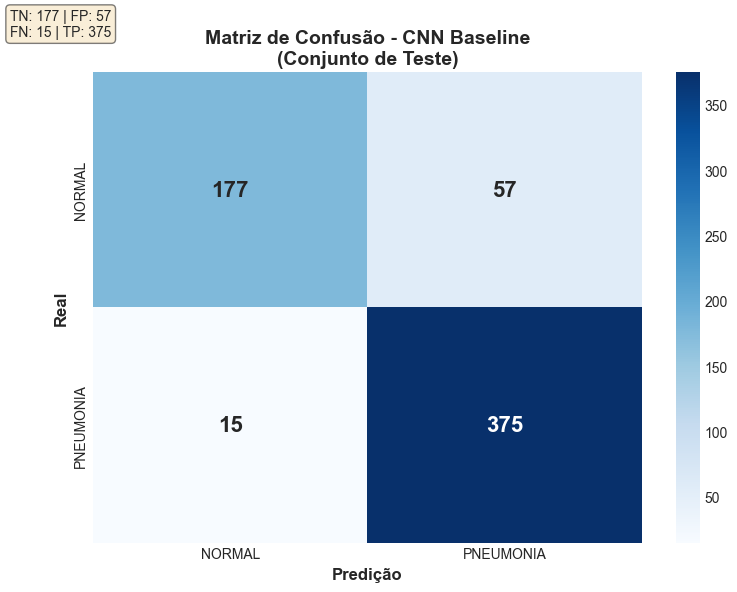

✅ Matriz de confusão salva em: results/cnn_baseline_confusion_matrix.png

📊 INTERPRETAÇÃO DA MATRIZ DE CONFUSÃO:

   ✅ True Negatives  (TN): 177 - NORMAL corretamente identificado
   ⚠️  False Positives (FP):  57 - NORMAL classificado como PNEUMONIA (alarme falso)
   🔴 False Negatives (FN):  15 - PNEUMONIA classificado como NORMAL (caso perdido!)
   ✅ True Positives  (TP): 375 - PNEUMONIA corretamente identificado

🏥 ANÁLISE CLÍNICA:

   ⚠️  57 alarmes falsos - pacientes saudáveis diagnosticados com PNEUMONIA
      Pode gerar exames adicionais desnecessários.



In [30]:
# Criar matriz de confusão detalhada

print("=" * 60)
print("📊 MATRIZ DE CONFUSÃO")
print("=" * 60)
print()

# Calcular matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax, annot_kws={'size': 16, 'weight': 'bold'})

ax.set_xlabel('Predição', fontsize=12, fontweight='bold')
ax.set_ylabel('Real', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusão - CNN Baseline\n(Conjunto de Teste)', 
             fontsize=14, fontweight='bold')

# Adicionar legendas explicativas
textstr = f'TN: {cm[0,0]} | FP: {cm[0,1]}\nFN: {cm[1,0]} | TP: {cm[1,1]}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=fig.transFigure, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'cnn_baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de confusão salva em: results/cnn_baseline_confusion_matrix.png")
print()

# Explicar os valores
TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

print("📊 INTERPRETAÇÃO DA MATRIZ DE CONFUSÃO:")
print()
print(f"   ✅ True Negatives  (TN): {TN:>3} - NORMAL corretamente identificado")
print(f"   ⚠️  False Positives (FP): {FP:>3} - NORMAL classificado como PNEUMONIA (alarme falso)")
print(f"   🔴 False Negatives (FN): {FN:>3} - PNEUMONIA classificado como NORMAL (caso perdido!)")
print(f"   ✅ True Positives  (TP): {TP:>3} - PNEUMONIA corretamente identificado")
print()

# Análise clínica
print("🏥 ANÁLISE CLÍNICA:")
print()
if FN > FP:
    print(f"   ⚠️  ATENÇÃO: {FN} casos de PNEUMONIA NÃO foram detectados!")
    print("      Isso é mais grave que alarmes falsos em contexto médico.")
elif FP > 10:
    print(f"   ⚠️  {FP} alarmes falsos - pacientes saudáveis diagnosticados com PNEUMONIA")
    print("      Pode gerar exames adicionais desnecessários.")
else:
    print("   ✅ Boa distribuição de erros!")

print()
print("=" * 60)


📊 RELATÓRIO DE CLASSIFICAÇÃO COMPLETO

              precision    recall  f1-score   support

      NORMAL     0.9219    0.7564    0.8310       234
   PNEUMONIA     0.8681    0.9615    0.9124       390

    accuracy                         0.8846       624
   macro avg     0.8950    0.8590    0.8717       624
weighted avg     0.8882    0.8846    0.8819       624



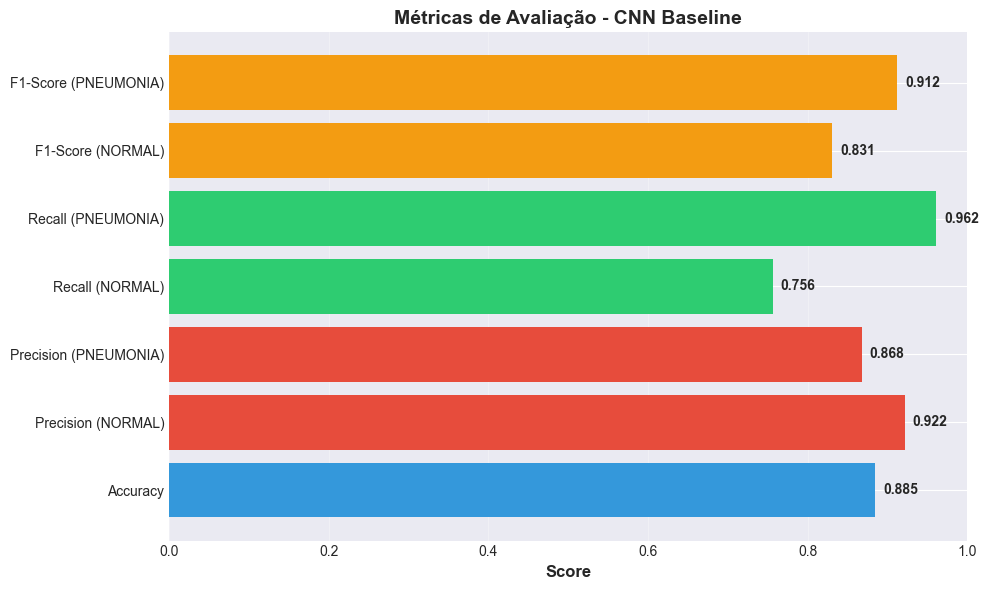


✅ Gráfico de métricas salvo em: results/cnn_baseline_metrics_detailed.png



In [31]:
# Relatório de classificação completo

print("=" * 60)
print("📊 RELATÓRIO DE CLASSIFICAÇÃO COMPLETO")
print("=" * 60)
print()

# Gerar relatório de classificação
report = classification_report(y_true, y_pred_classes, 
                               target_names=CLASS_NAMES,
                               output_dict=True)

# Exibir relatório formatado
print(classification_report(y_true, y_pred_classes, 
                           target_names=CLASS_NAMES, 
                           digits=4))

# Criar visualização das métricas
metrics_data = {
    'Accuracy': [report['accuracy']],
    'Precision (NORMAL)': [report['NORMAL']['precision']],
    'Precision (PNEUMONIA)': [report['PNEUMONIA']['precision']],
    'Recall (NORMAL)': [report['NORMAL']['recall']],
    'Recall (PNEUMONIA)': [report['PNEUMONIA']['recall']],
    'F1-Score (NORMAL)': [report['NORMAL']['f1-score']],
    'F1-Score (PNEUMONIA)': [report['PNEUMONIA']['f1-score']],
}

fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = list(metrics_data.keys())
metrics_values = [metrics_data[k][0] for k in metrics_names]

bars = ax.barh(metrics_names, metrics_values, color=['#3498db', '#e74c3c', '#e74c3c', '#2ecc71', '#2ecc71', '#f39c12', '#f39c12'])
ax.set_xlabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Métricas de Avaliação - CNN Baseline', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.0)
ax.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.3f}', 
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'cnn_baseline_metrics_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print()
print("✅ Gráfico de métricas salvo em: results/cnn_baseline_metrics_detailed.png")
print()
print("=" * 60)


In [32]:
# Criar função para predição interativa

def predict_pneumonia(image_path, modelo=best_model, show_plot=True):
    """
    Função para prever se uma imagem de raio-X tem PNEUMONIA ou é NORMAL
    
    Args:
        image_path: Caminho para a imagem
        modelo: Modelo treinado (default: best_model)
        show_plot: Se True, mostra visualização (default: True)
    
    Returns:
        classe: 'NORMAL' ou 'PNEUMONIA'
        probabilidade: Probabilidade da predição (0-1)
    """
    # Carregar e pré-processar imagem
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch
    
    # Fazer predição
    prediction = modelo.predict(img_array, verbose=0)[0][0]
    
    # Determinar classe
    classe = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    probabilidade = prediction if prediction > 0.5 else (1 - prediction)
    
    # Visualizar se solicitado
    if show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Definir cor baseado na predição
        color = 'red' if classe == "PNEUMONIA" else 'green'
        
        ax.set_title(f'Predição: {classe}\nConfiança: {probabilidade:.2%}', 
                    fontsize=14, fontweight='bold', color=color, pad=20)
        
        plt.tight_layout()
        plt.show()
    
    return classe, probabilidade



print("=" * 60)
print("✅ FUNÇÃO DE PREDIÇÃO CRIADA!")
print("=" * 60)
print()
print("🔮 Como usar:")
print()
print("   # Exemplo:")
print("   classe, prob = predict_pneumonia('caminho/para/imagem.jpeg')")
print("   print(f'Resultado: {classe} ({prob:.2%})')")
print()
print("=" * 60)


✅ FUNÇÃO DE PREDIÇÃO CRIADA!

🔮 Como usar:

   # Exemplo:
   classe, prob = predict_pneumonia('caminho/para/imagem.jpeg')
   print(f'Resultado: {classe} ({prob:.2%})')



## Modelo 2: Transfer Learning {#7-transfer-learning}

### 🎯 Objetivo

Vamos implementar Transfer Learning usando modelo pré-treinado (VGG16 ou ResNet50) para melhorar os resultados obtidos com a CNN baseline.


### 📋 O que vamos fazer
1. **Carregar modelo pré-treinado** (VGG16 ou ResNet50) sem camada de classificação
2. **Congelar camadas base** para não treinar pesos já aprendidos
3. **Adicionar camadas customizadas** para classificação NORMAL vs PNEUMONIA
4. **Treinar apenas camadas novas** (mais rápido e eficiente)

---

In [33]:
# Escolher modelo base para Transfer Learning

print("=" * 60)
print("🔧 CONFIGURANDO TRANSFER LEARNING")
print("=" * 60)
print()

# Decisão: VGG16 vs ResNet50
# VGG16: Mais simples, menos parâmetros, boa base para começar
# ResNet50: Mais profundo, melhor performance, mas mais pesado

MODEL_CHOICE = 'VGG16'  # Ou 'ResNet50'

print(f"📦 Modelo escolhido: {MODEL_CHOICE}")
print()

# Limpar sessão do Keras
tf.keras.backend.clear_session()

# Carregar modelo pré-treinado SEM top (camada de classificação)
if MODEL_CHOICE == 'VGG16':
    base_model = VGG16(
        weights='imagenet',           # Pesos do ImageNet
        include_top=False,             # Remover camada de classificação
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    )
elif MODEL_CHOICE == 'ResNet50':
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    )

print(f"✅ Modelo {MODEL_CHOICE} carregado com pesos do ImageNet!")
print()

# Congelar TODAS as camadas do modelo base (não treinar)
base_model.trainable = False

print(f"🔒 Camadas do modelo base CONGELADAS")
print(f"   → Não serão treinadas, apenas usadas para extração de features")
print()

print("=" * 60)
print("RESUMO DO MODELO BASE")
print("=" * 60)
print()
base_model.summary()


🔧 CONFIGURANDO TRANSFER LEARNING

📦 Modelo escolhido: VGG16

✅ Modelo VGG16 carregado com pesos do ImageNet!

🔒 Camadas do modelo base CONGELADAS
   → Não serão treinadas, apenas usadas para extração de features

RESUMO DO MODELO BASE



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# Construir modelo completo com camadas customizadas

print("=" * 60)
print("🏗️  CONSTRUINDO MODELO TRANSFER LEARNING COMPLETO")
print("=" * 60)
print()

# Criar modelo Sequential adicionando camadas personalizadas
model_tl = models.Sequential([
    # Modelo base pré-treinado (congelado)
    base_model,
    
    # GlobalAveragePooling2D: Reduz dimensionalidade (melhor que Flatten)
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    
    # Camada densa com BatchNorm e Dropout
    layers.Dense(256, activation='relu', name='fc1'),
    layers.BatchNormalization(name='bn1'),
    layers.Dropout(0.5, name='dropout1'),
    
    # Segunda camada densa (opcional, mas ajuda)
    layers.Dense(128, activation='relu', name='fc2'),
    layers.Dropout(0.3, name='dropout2'),
    
    # Camada de saída (classificação binária)
    layers.Dense(1, activation='sigmoid', name='output')
], name=f'TransferLearning_{MODEL_CHOICE}')

print(f"✅ Modelo Transfer Learning criado!")
print()

print("=" * 60)
print("RESUMO DO MODELO COMPLETO")
print("=" * 60)
print()
model_tl.summary()

print()
print("=" * 60)
print("ANÁLISE DE PARÂMETROS")
print("=" * 60)
print()

# Calcular parâmetros
total_params = model_tl.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model_tl.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"📊 Total de parâmetros: {total_params:,}")
print(f"   • Treináveis: {trainable_params:,} (apenas camadas novas)")
print(f"   • Não-treináveis: {non_trainable_params:,} (modelo base congelado)")
print()
print(f"💡 Vantagem: Treinar apenas {trainable_params:,} parâmetros é muito mais rápido!")
print("=" * 60)


🏗️  CONSTRUINDO MODELO TRANSFER LEARNING COMPLETO

✅ Modelo Transfer Learning criado!

RESUMO DO MODELO COMPLETO



Model: "TransferLearning_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,065 (56.76 MB)

 Trainable params: 164,865 (644.00 KB)

 Non-trainable params: 14,715,200 (56.13 MB)


ANÁLISE DE PARÂMETROS

📊 Total de parâmetros: 14,880,065
   • Treináveis: 164,865 (apenas camadas novas)
   • Não-treináveis: 14,715,200 (modelo base congelado)

💡 Vantagem: Treinar apenas 164,865 parâmetros é muito mais rápido!


In [35]:
# Compilar modelo Transfer Learning

print("=" * 60)
print("⚙️  COMPILANDO MODELO TRANSFER LEARNING")
print("=" * 60)
print()

# Compilar com mesmas configurações da CNN baseline para comparação justa
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("✅ Modelo compilado com sucesso!")
print()
print("📊 CONFIGURAÇÕES:")
print(f"   • Otimizador: Adam")
print(f"   • Learning Rate: {LEARNING_RATE}")
print(f"   • Loss Function: binary_crossentropy")
print(f"   • Métricas: accuracy, precision, recall, AUC")
print()
print("=" * 60)
print("✅ MODELO PRONTO PARA TREINAMENTO!")
print("=" * 60)


⚙️  COMPILANDO MODELO TRANSFER LEARNING

✅ Modelo compilado com sucesso!

📊 CONFIGURAÇÕES:
   • Otimizador: Adam
   • Learning Rate: 0.001
   • Loss Function: binary_crossentropy
   • Métricas: accuracy, precision, recall, AUC

✅ MODELO PRONTO PARA TREINAMENTO!


In [36]:
# Configurar callbacks para Transfer Learning

print("=" * 60)
print("🔧 CONFIGURANDO CALLBACKS PARA TRANSFER LEARNING")
print("=" * 60)
print()

# EarlyStopping
early_stopping_tl = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Transfer Learning converge mais rápido, menos patience
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# ModelCheckpoint - salvar melhor modelo
checkpoint_tl = ModelCheckpoint(
    filepath=str(MODELS_DIR / f'transfer_learning_{MODEL_CHOICE.lower()}_best.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

# ReduceLROnPlateau
reduce_lr_tl = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

# Lista de callbacks
callbacks_list_tl = [early_stopping_tl, checkpoint_tl, reduce_lr_tl]

print("✅ Callbacks configurados:")
print()
print("   📊 EarlyStopping:")
print(f"      • Monitor: val_loss")
print(f"      • Patience: 5 epochs")
print()
print("   💾 ModelCheckpoint:")
print(f"      • Arquivo: models/transfer_learning_{MODEL_CHOICE.lower()}_best.keras")
print(f"      • Monitor: val_accuracy")
print()
print("   📉 ReduceLROnPlateau:")
print(f"      • Factor: 0.5 | Patience: 3")
print()
print("=" * 60)


🔧 CONFIGURANDO CALLBACKS PARA TRANSFER LEARNING

✅ Callbacks configurados:

   📊 EarlyStopping:
      • Monitor: val_loss
      • Patience: 5 epochs

   💾 ModelCheckpoint:
      • Arquivo: models/transfer_learning_vgg16_best.keras
      • Monitor: val_accuracy

   📉 ReduceLROnPlateau:
      • Factor: 0.5 | Patience: 3



In [37]:
# # TREINAR MODELO TRANSFER LEARNING

# print("=" * 60)
# print("🚀 INICIANDO TREINAMENTO - TRANSFER LEARNING")
# print("=" * 60)
# print()
# print("⏰ ESTIMATIVA DE TEMPO:")
# print("   • Com CPU: ~30-60 minutos (mais rápido que CNN baseline!)")
# print("   • Com GPU: ~10-15 minutos")
# print()
# print(f"📊 CONFIGURAÇÕES:")
# print(f"   • Modelo Base: {MODEL_CHOICE}")
# print(f"   • Epochs: {EPOCHS}")
# print(f"   • Batch size: {BATCH_SIZE}")
# print(f"   • Learning rate: {LEARNING_RATE}")
# print(f"   • Parâmetros treináveis: {trainable_params:,}")
# print()
# print("=" * 60)
# print("🔥 INICIANDO TREINAMENTO...")
# print("=" * 60)
# print()

# # Registrar tempo
# import time
# start_time_tl = time.time()

# # TREINAR MODELO
# history_tl = model_tl.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=validation_generator,
#     callbacks=callbacks_list_tl,
#     class_weight=class_weights,
#     verbose=1
# )

# # Calcular tempo total
# end_time_tl = time.time()
# training_time_tl = end_time_tl - start_time_tl

# print()
# print("=" * 60)
# print("✅ TREINAMENTO CONCLUÍDO!")
# print("=" * 60)
# print()
# print(f"⏱️  Tempo total: {training_time_tl/60:.2f} minutos ({training_time_tl:.0f} segundos)")
# print(f"⏱️  Tempo médio por epoch: {training_time_tl/len(history_tl.history['loss']):.2f} segundos")
# print()
# print(f"📊 RESULTADOS FINAIS:")
# print(f"   • Train Accuracy: {history_tl.history['accuracy'][-1]:.4f}")
# print(f"   • Val Accuracy: {history_tl.history['val_accuracy'][-1]:.4f}")
# print(f"   • Train Loss: {history_tl.history['loss'][-1]:.4f}")
# print(f"   • Val Loss: {history_tl.history['val_loss'][-1]:.4f}")
# print()
# print(f"💾 Melhor modelo salvo em: models/transfer_learning_{MODEL_CHOICE.lower()}_best.keras")
# print("=" * 60)


In [38]:
# Carregar e avaliar modelo Transfer Learning no conjunto de teste

print("=" * 60)
print("🧪 AVALIAÇÃO - TRANSFER LEARNING VGG16")
print("=" * 60)
print()

# Tentar carregar o modelo com safe_mode=False
print("📂 Carregando modelo treinado...")
try:
    model_tl_best = tf.keras.models.load_model(
        MODELS_DIR / 'transfer_learning_vgg16_best.keras',
        safe_mode=False  # Desabilitar verificações de segurança
    )
    print("✅ Modelo carregado com sucesso!")
except Exception as e:
    print(f"❌ Erro ao carregar modelo: {e}")
    print("\n⚠️  SOLUÇÃO: Vamos recriar e carregar apenas os pesos")
    
    # Recriar arquitetura EXATAMENTE como no treinamento
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    )
    base_model.trainable = False
    
    model_tl_best = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name='global_avg_pool'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.BatchNormalization(name='bn1'),
        layers.Dropout(0.5, name='dropout1'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name=f'TransferLearning_VGG16')
    
    # Carregar apenas os pesos
    model_tl_best.load_weights(MODELS_DIR / 'transfer_learning_vgg16_best.keras')
    print("✅ Pesos do modelo carregados com sucesso!")

print()

# Recompilar com métricas
model_tl_best.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
print("✅ Modelo recompilado com métricas!")
print()

# Avaliar no conjunto de teste
print("=" * 60)
print("🔍 AVALIANDO NO CONJUNTO DE TESTE")
print("=" * 60)
print()

# Resetar test_generator
test_generator.reset()

test_results_tl = model_tl_best.evaluate(test_generator, verbose=1)

print()
print("=" * 60)
print("📊 RESULTADOS NO CONJUNTO DE TESTE - TRANSFER LEARNING")
print("=" * 60)
print()
print(f"   • Test Loss:      {test_results_tl[0]:.4f}")
print(f"   • Test Accuracy:  {test_results_tl[1]:.4f} ({test_results_tl[1]*100:.2f}%)")
print(f"   • Test Precision: {test_results_tl[2]:.4f} ({test_results_tl[2]*100:.2f}%)")
print(f"   • Test Recall:    {test_results_tl[3]:.4f} ({test_results_tl[3]*100:.2f}%)")
print(f"   • Test AUC:       {test_results_tl[4]:.4f}")
print()

# Interpretação clínica
print("🏥 INTERPRETAÇÃO CLÍNICA:")
print()
print(f"   📊 Acurácia: {test_results_tl[1]*100:.2f}%")
print(f"      → De todas as predições, {test_results_tl[1]*100:.1f}% estão corretas")
print()
print(f"   🎯 Precisão: {test_results_tl[2]*100:.2f}%")
print(f"      → De todos os casos que prevemos como PNEUMONIA, {test_results_tl[2]*100:.1f}% realmente são")
print()
print(f"   🔍 Recall: {test_results_tl[3]*100:.2f}%")
print(f"      → De todos os casos REAIS de PNEUMONIA, detectamos {test_results_tl[3]*100:.1f}%")
print()

# Análise de Recall
if test_results_tl[3] >= 0.90:
    print("   ✅ EXCELENTE Recall! O modelo detecta >90% dos casos de PNEUMONIA.")
elif test_results_tl[3] >= 0.80:
    print("   ✅ BOM Recall! Detecta a maioria dos casos.")
else:
    print("   ⚠️  Recall pode melhorar.")

print()
print("=" * 60)


🧪 AVALIAÇÃO - TRANSFER LEARNING VGG16

📂 Carregando modelo treinado...
❌ Erro ao carregar modelo: Layer "fc1" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_69>, <KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_70>]

⚠️  SOLUÇÃO: Vamos recriar e carregar apenas os pesos
✅ Pesos do modelo carregados com sucesso!

✅ Modelo recompilado com métricas!

🔍 AVALIANDO NO CONJUNTO DE TESTE

20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9071 - auc: 0.9581 - loss: 0.2613 - precision: 0.9323 - recall: 0.9179

📊 RESULTADOS NO CONJUNTO DE TESTE - TRANSFER LEARNING

   • Test Loss:      0.2613
   • Test Accuracy:  0.9071 (90.71%)
   • Test Precision: 0.9323 (93.23%)
   • Test Recall:    0.9179 (91.79%)
   • Test AUC:       0.9581

🏥 INTERPRETAÇÃO CLÍNICA:

   📊 Acurácia: 90.71%
      → De todas as predições, 90.7% estão corr

🔮 GERANDO PREDIÇÕES - TRANSFER LEARNING

📊 Gerando predições...
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step

✅ Predições geradas!
   • Total de imagens: 624

📊 DISTRIBUIÇÃO DAS PREDIÇÕES:
   • Predito como NORMAL (0):    240 imagens
   • Predito como PNEUMONIA (1): 384 imagens

📊 DISTRIBUIÇÃO REAL:
   • NORMAL (0):    234 imagens
   • PNEUMONIA (1): 390 imagens

📊 ACERTOS POR CLASSE:
   • NORMAL:    208/234 (88.9%)
   • PNEUMONIA: 358/390 (91.8%)

📊 MATRIZ DE CONFUSÃO - TRANSFER LEARNING



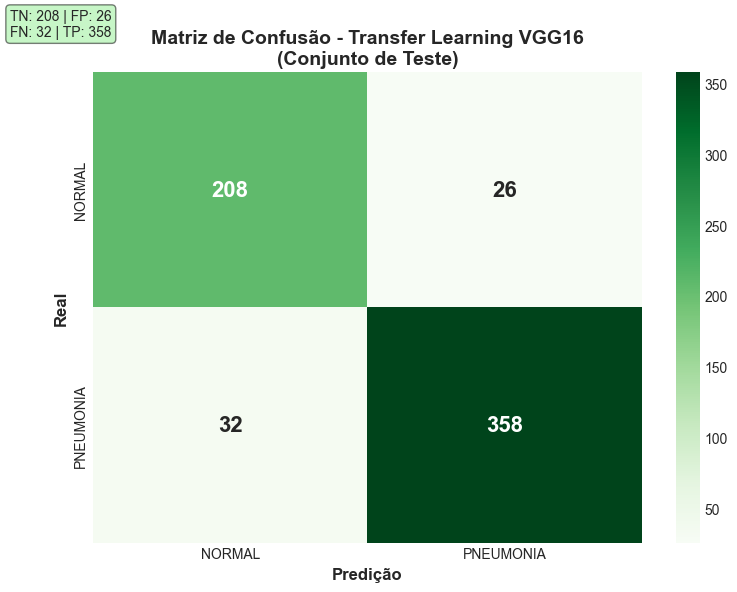

✅ Matriz de confusão salva em: results/transfer_learning_confusion_matrix.png

📊 INTERPRETAÇÃO DA MATRIZ DE CONFUSÃO:

   ✅ True Negatives  (TN): 208 - NORMAL corretamente identificado
   ⚠️  False Positives (FP):  26 - NORMAL classificado como PNEUMONIA (alarme falso)
   🔴 False Negatives (FN):  32 - PNEUMONIA classificado como NORMAL (caso perdido!)
   ✅ True Positives  (TP): 358 - PNEUMONIA corretamente identificado

🏥 ANÁLISE CLÍNICA:

   ⚠️  ATENÇÃO: 32 casos de PNEUMONIA NÃO foram detectados!
      Isso é mais grave que alarmes falsos em contexto médico.



In [39]:
# Gerar predições para análise detalhada

print("=" * 60)
print("🔮 GERANDO PREDIÇÕES - TRANSFER LEARNING")
print("=" * 60)
print()

# Resetar generator
test_generator.reset()

# Gerar predições
print("📊 Gerando predições...")
y_pred_proba_tl = model_tl_best.predict(test_generator, verbose=1)
y_pred_classes_tl = (y_pred_proba_tl > 0.5).astype(int).flatten()

# Labels verdadeiros
y_true_tl = test_generator.classes

print()
print(f"✅ Predições geradas!")
print(f"   • Total de imagens: {len(y_pred_classes_tl)}")
print()

# Distribuição
print("📊 DISTRIBUIÇÃO DAS PREDIÇÕES:")
print(f"   • Predito como NORMAL (0):    {(y_pred_classes_tl == 0).sum():>3} imagens")
print(f"   • Predito como PNEUMONIA (1): {(y_pred_classes_tl == 1).sum():>3} imagens")
print()

print("📊 DISTRIBUIÇÃO REAL:")
print(f"   • NORMAL (0):    {(y_true_tl == 0).sum():>3} imagens")
print(f"   • PNEUMONIA (1): {(y_true_tl == 1).sum():>3} imagens")
print()

# Calcular acertos por classe
correct_normal_tl = ((y_pred_classes_tl == 0) & (y_true_tl == 0)).sum()
correct_pneumonia_tl = ((y_pred_classes_tl == 1) & (y_true_tl == 1)).sum()
total_normal_tl = (y_true_tl == 0).sum()
total_pneumonia_tl = (y_true_tl == 1).sum()

print("📊 ACERTOS POR CLASSE:")
print(f"   • NORMAL:    {correct_normal_tl}/{total_normal_tl} ({correct_normal_tl/total_normal_tl*100:.1f}%)")
print(f"   • PNEUMONIA: {correct_pneumonia_tl}/{total_pneumonia_tl} ({correct_pneumonia_tl/total_pneumonia_tl*100:.1f}%)")
print()

# Matriz de Confusão
print("=" * 60)
print("📊 MATRIZ DE CONFUSÃO - TRANSFER LEARNING")
print("=" * 60)
print()

cm_tl = confusion_matrix(y_true_tl, y_pred_classes_tl)

# Visualizar
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax, annot_kws={'size': 16, 'weight': 'bold'})

ax.set_xlabel('Predição', fontsize=12, fontweight='bold')
ax.set_ylabel('Real', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusão - Transfer Learning VGG16\n(Conjunto de Teste)', 
             fontsize=14, fontweight='bold')

# Adicionar legendas
TN_tl, FP_tl, FN_tl, TP_tl = cm_tl[0,0], cm_tl[0,1], cm_tl[1,0], cm_tl[1,1]
textstr = f'TN: {TN_tl} | FP: {FP_tl}\nFN: {FN_tl} | TP: {TP_tl}'
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=fig.transFigure, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'transfer_learning_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de confusão salva em: results/transfer_learning_confusion_matrix.png")
print()

# Explicar valores
print("📊 INTERPRETAÇÃO DA MATRIZ DE CONFUSÃO:")
print()
print(f"   ✅ True Negatives  (TN): {TN_tl:>3} - NORMAL corretamente identificado")
print(f"   ⚠️  False Positives (FP): {FP_tl:>3} - NORMAL classificado como PNEUMONIA (alarme falso)")
print(f"   🔴 False Negatives (FN): {FN_tl:>3} - PNEUMONIA classificado como NORMAL (caso perdido!)")
print(f"   ✅ True Positives  (TP): {TP_tl:>3} - PNEUMONIA corretamente identificado")
print()

# Análise clínica
print("🏥 ANÁLISE CLÍNICA:")
print()
if FN_tl < FP_tl:
    print(f"   ✅ ÓTIMO! Apenas {FN_tl} casos de PNEUMONIA não foram detectados!")
    print("      Melhor pecar por excesso (FP) que deixar passar casos graves (FN).")
elif FN_tl > FP_tl:
    print(f"   ⚠️  ATENÇÃO: {FN_tl} casos de PNEUMONIA NÃO foram detectados!")
    print("      Isso é mais grave que alarmes falsos em contexto médico.")
else:
    print("   ✅ Distribuição equilibrada de erros!")

print()
print("=" * 60)


📊 COMPARAÇÃO: CNN BASELINE vs TRANSFER LEARNING

           CNN Baseline  Transfer Learning  Melhoria (%)
Accuracy         0.8846           0.907051          2.54
Precision        0.8681           0.932292          7.39
Recall           0.9615           0.917949         -4.53
AUC              0.9437           0.958087          1.52



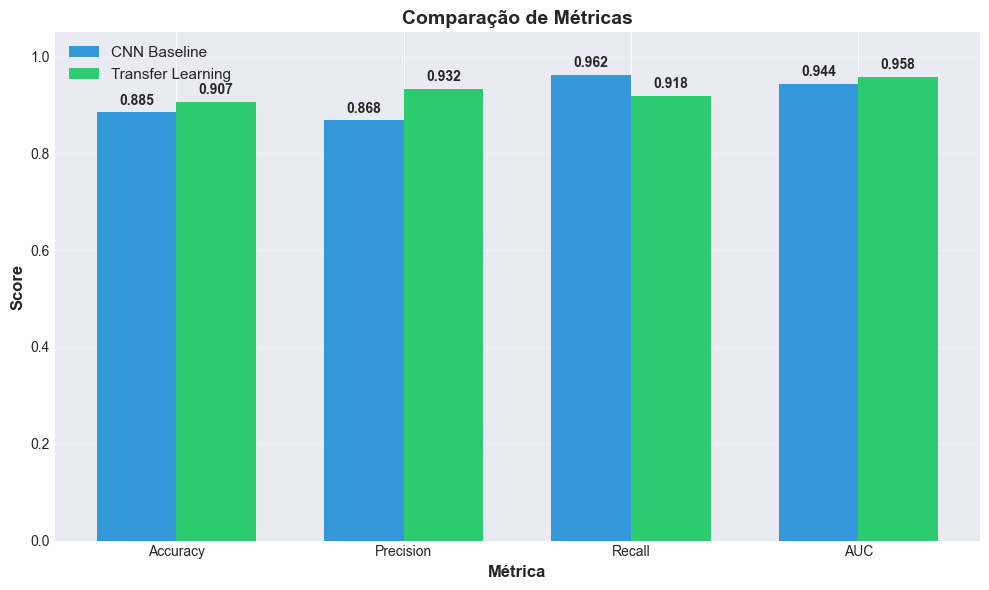

✅ Gráfico de métricas salvo em: results/comparison_metrics.png



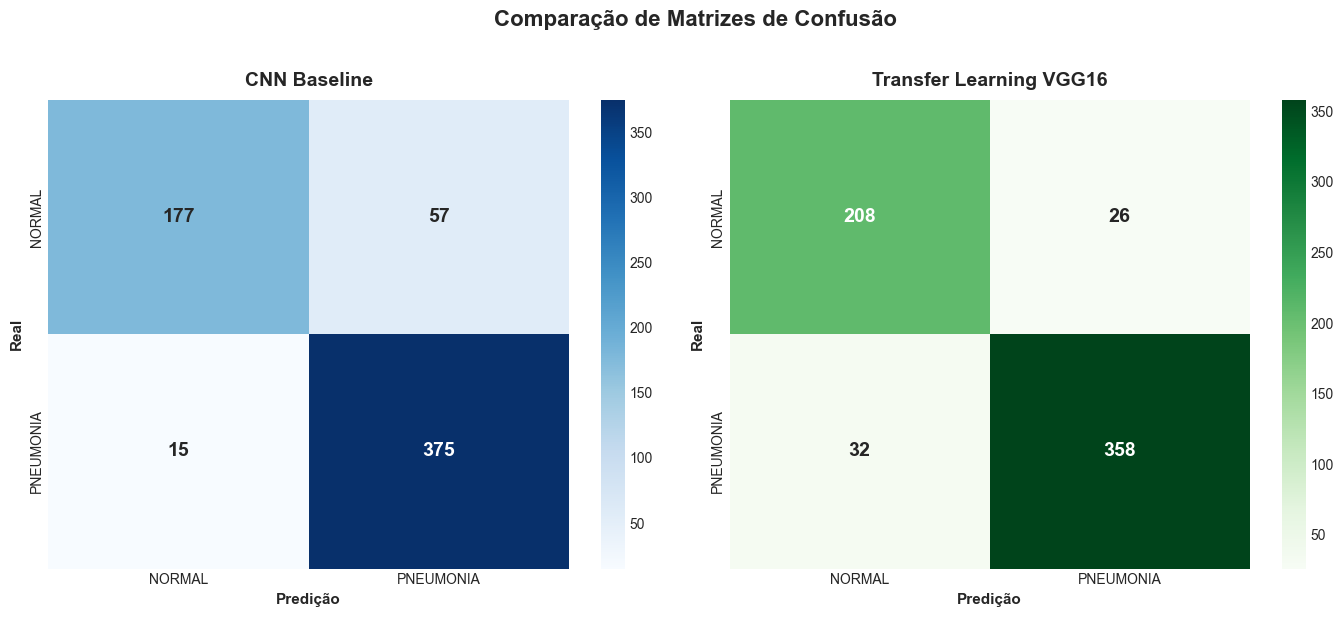

✅ Matrizes de confusão salvas em: results/comparison_confusion_matrices.png

🏆 CONCLUSÃO DA COMPARAÇÃO:

   ✅ Transfer Learning SUPEROU CNN Baseline!
      Melhoria de 2.25% na acurácia

   🔍 Comparação de Recall (CRÍTICO para medicina):
      • CNN Baseline:      96.15%
      • Transfer Learning: 91.79%
      → CNN Baseline 4.36% MELHOR ✅

   🔴 Casos de PNEUMONIA não detectados (False Negatives):
      • CNN Baseline:      15 casos
      • Transfer Learning: 32 casos
      → CNN Baseline perdeu 17 casos A MENOS! ✅



In [41]:
# Comparar CNN Baseline vs Transfer Learning

print("=" * 60)
print("📊 COMPARAÇÃO: CNN BASELINE vs TRANSFER LEARNING")
print("=" * 60)
print()

# Resultados CNN Baseline (da Etapa 3)
cnn_results = {
    'Accuracy': 0.8846,
    'Precision': 0.8681,
    'Recall': 0.9615,
    'AUC': 0.9437
}

# Resultados Transfer Learning (acabamos de calcular)
tl_results = {
    'Accuracy': test_results_tl[1],
    'Precision': test_results_tl[2],
    'Recall': test_results_tl[3],
    'AUC': test_results_tl[4]
}

# Criar DataFrame comparativo
comparison_df = pd.DataFrame({
    'CNN Baseline': cnn_results,
    'Transfer Learning': tl_results
})

# Calcular melhoria
comparison_df['Melhoria (%)'] = ((comparison_df['Transfer Learning'] - comparison_df['CNN Baseline']) / comparison_df['CNN Baseline'] * 100).round(2)

print(comparison_df.to_string())
print()

# GRÁFICO 1: Barras lado a lado
fig1, ax = plt.subplots(figsize=(10, 6))

metrics = list(cnn_results.keys())
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, list(cnn_results.values()), width, label='CNN Baseline', color='#3498db')
bars2 = ax.bar(x + width/2, list(tl_results.values()), width, label='Transfer Learning', color='#2ecc71')

ax.set_xlabel('Métrica', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Comparação de Métricas', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de métricas salvo em: results/comparison_metrics.png")
print()

# GRÁFICO 2: Matrizes de Confusão lado a lado
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# CNN Baseline
cm_cnn = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 14, 'weight': 'bold'}, cbar=True)
ax1.set_title('CNN Baseline', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Predição', fontweight='bold', fontsize=11)
ax1.set_ylabel('Real', fontweight='bold', fontsize=11)

# Transfer Learning
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 14, 'weight': 'bold'}, cbar=True)
ax2.set_title('Transfer Learning VGG16', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Predição', fontweight='bold', fontsize=11)
ax2.set_ylabel('Real', fontweight='bold', fontsize=11)

plt.suptitle('Comparação de Matrizes de Confusão', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matrizes de confusão salvas em: results/comparison_confusion_matrices.png")
print()

# Análise final
print("=" * 60)
print("🏆 CONCLUSÃO DA COMPARAÇÃO:")
print("=" * 60)
print()

# Comparar acurácia
acc_diff = (tl_results['Accuracy'] - cnn_results['Accuracy']) * 100
if tl_results['Accuracy'] > cnn_results['Accuracy']:
    print(f"   ✅ Transfer Learning SUPEROU CNN Baseline!")
    print(f"      Melhoria de {acc_diff:.2f}% na acurácia")
elif tl_results['Accuracy'] < cnn_results['Accuracy']:
    print(f"   ⚠️  CNN Baseline teve melhor acurácia ({-acc_diff:.2f}% a mais)")
else:
    print(f"   ⚖️  Empate técnico na acurácia!")

print()

# Comparar Recall
recall_diff = (tl_results['Recall'] - cnn_results['Recall']) * 100
print(f"   🔍 Comparação de Recall (CRÍTICO para medicina):")
print(f"      • CNN Baseline:      {cnn_results['Recall']*100:.2f}%")
print(f"      • Transfer Learning: {tl_results['Recall']*100:.2f}%")
if recall_diff > 0:
    print(f"      → Transfer Learning {recall_diff:.2f}% MELHOR ✅")
elif recall_diff < 0:
    print(f"      → CNN Baseline {-recall_diff:.2f}% MELHOR ✅")
else:
    print(f"      → Empate técnico!")

print()

# Comparar False Negatives (casos perdidos)
TN_cnn, FP_cnn, FN_cnn, TP_cnn = cm_cnn[0,0], cm_cnn[0,1], cm_cnn[1,0], cm_cnn[1,1]
print(f"   🔴 Casos de PNEUMONIA não detectados (False Negatives):")
print(f"      • CNN Baseline:      {FN_cnn} casos")
print(f"      • Transfer Learning: {FN_tl} casos")
if FN_tl < FN_cnn:
    print(f"      → Transfer Learning perdeu {FN_cnn - FN_tl} casos A MENOS! ✅")
elif FN_tl > FN_cnn:
    print(f"      → CNN Baseline perdeu {FN_tl - FN_cnn} casos A MENOS! ✅")
else:
    print(f"      → Empate: ambos perderam {FN_tl} casos")

print()
print("=" * 60)
